In [1]:
# Add noise to the simulated light curves
# By add noise from Kepler Dataset
# Here entire std dev is considered
# Kepler_noise_addn_v1.ipynb


# In other versions more refined std_dev will be considered

In [2]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
import random 


2023-09-15 12:02:10.991366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 12:02:11.853107: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


In [3]:
# 1. Load Dataset
## Load Train Set
train_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled5.npy'
train_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_5.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
vald_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled4.npy'
vald_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_4.npy'
vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of number of dataset
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")

Train Set: No. of LC = No. of shapes
Vald Set: No. of LC = No. of shapes


In [4]:
# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)
print("Normalized the shape")


Normalized the shape


In [5]:
# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))
print("Normalized the light curves")


Normalized the light curves


In [6]:
# Add flat line towards left and right of dip
# 50 data points on each side
# 3. Extend the lightcurves
## - Train Set
train_lc_scaled_append = np.ones((train_lc.shape[0],120))
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print("len(train_lc_scaled_append[0,10:110]) = ",len(train_lc_scaled_append[0,10:110]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,10:110] = train_lc_scaled[i]

## - Vald Set
vald_lc_scaled_append = np.ones((vald_lc.shape[0],120))
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_append[i,10:110] = vald_lc_scaled[i]
print("Extended the light curves")

train_lc_scaled_append.shape =  (132136, 120)
len(train_lc_scaled_append[0,10:110]) =  100
Extended the light curves


Don't run above code more than once anymore

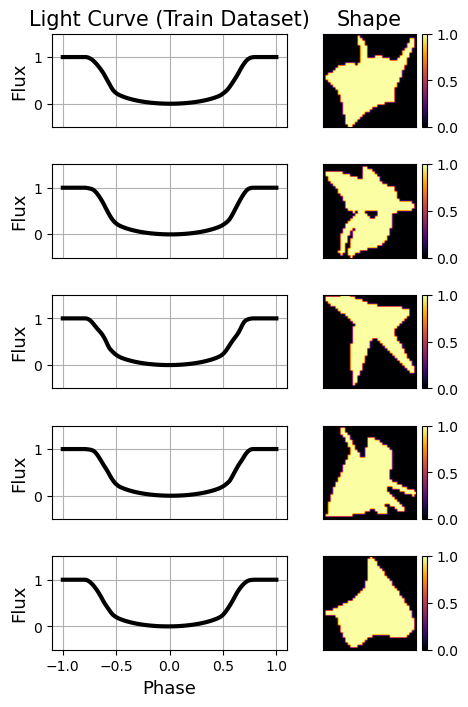

In [7]:
# Plot - Train LCs
num = 5
fig,ax=plt.subplots(num,2, figsize=(5,8), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(train_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, train_lc_scaled_append[k],color = 'black',linewidth='3')
    ax[i][0].grid('on')
    i = i + 1

In [8]:
filenames = ['/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00000-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00001-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00002-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00003-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00004-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00005-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00006-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/train-00007-of-00008',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/val-00000-of-00001',
             '/home/abraham/Documents/tfr_shallue/tfr_all/tfrecord/test-00000-of-00001']
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

2023-09-15 12:02:25.773997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30931 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [9]:
feature_description = {
    'global_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'local_view': tf.io.FixedLenSequenceFeature([], tf.float32, default_value=0.0,allow_missing=True),
    'av_training_set': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

# At this point the dataset contains serialized tf.train.Example messages.
# When iterated over it returns these as scalar string tensors.
# Use the .take method to only show the first 10 records.
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))
  
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset


<tf.Tensor: shape=(), dtype=string, numpy=b'\n\xdbG\n\x15\n\x0ctce_plnt_num\x12\x05\x1a\x03\n\x01\x02\n\x19\n\x0fav_training_set\x12\x06\n\x04\n\x02PC\n\x1b\n\x0ftce_max_mult_ev\x12\x08\x12\x06\n\x04H\xe1\x06B\n\x1a\n\x0espline_bkspace\x12\x08\x12\x06\n\x04\x9a\xa97@\n\x17\n\rav_pred_class\x12\x06\n\x04\n\x02PC\n\x15\n\ttce_depth\x12\x08\x12\x06\n\x043\x13PD\n\x16\n\ntce_impact\x12\x08\x12\x06\n\x04\x94\xf66?\n\x19\n\rtce_model_snr\x12\x08\x12\x06\n\x04\x14\xae\x02B\n\x14\n\x08tce_prad\x12\x08\x12\x06\n\x04\xecQ@@\n\x17\n\x0btce_time0bk\x12\x08\x12\x06\n\x04\x17\x193C\n\xda>\n\x0bglobal_view\x12\xca>\x12\xc7>\n\xc4>\x8a\x99\xbc<\xde\x8f\x9c\xbdl\xf5l<(s\r=o\x1f\xe8\xba\t\xcf\xbd\xbcG\n\xc2\xbc"\x1f\x17\xbc\xfd&\xd1\xbc\x15w*=f\xa1v\xbc\xea\x95\xf0\xbci\xcb\xf1<\x00\x00\x00\x00g6t\xbd\x1f\xf5\x9b=\xabg\x87<]\xc5\x1d=.\xc7\x83<\\0\xa0\xbd\xb0&\x00>\x98\xd6\xa6<\x96A)\xbcb\x84\x96\xbd\xb6)\xaa\xbd)\x08\x8b\xbc\x1c\x1cm>\xab\x16\xbb=}\\R=\xf3\x13b\xbc\x02\xe6\xc9\xbdg6t\xbd\x93\x17\xae\xbc

2023-09-15 12:02:26.593652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


<_MapDataset element_spec={'av_training_set': TensorSpec(shape=(), dtype=tf.string, name=None), 'global_view': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'local_view': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>

In [10]:
# Calculate the size of one light curve corresponding to 'local_view'
y = np.array([])
for elem in parsed_dataset.take(1):
  y = np.append(y,[elem['local_view']])
length_lc = len(y)
print("length_lc = " ,length_lc)


# Calculate total number of light curves
no_data = 0
for elem in parsed_dataset.as_numpy_iterator():
    no_data = no_data + 1
print('no_data = ',no_data)

2023-09-15 12:02:26.741533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2023-09-15 12:02:26.772501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


length_lc =  201
no_data =  15737


In [11]:
# convert all tf dataset to np array (light curve numpy array (lc_np_array))
lc_np_array = np.zeros(shape=(no_data,length_lc))
lc_np_array.shape


i = 0
for elem in parsed_dataset.as_numpy_iterator():
    lc_np_array[i] = elem['local_view'] #+1.0
    i = i + 1

print('lc_np_array[0] = ',lc_np_array[0])


lc_np_array[0] =  [-6.92397356e-02 -2.56392676e-02 -4.75080535e-02 -6.34126291e-02
 -2.86556520e-02 -7.22561181e-02 -7.22561181e-02  1.56303551e-02
  3.60595062e-02  5.99163622e-02  5.51175699e-02 -4.38746847e-02
  6.16987748e-03  4.48344424e-02  2.11146921e-02  1.93322822e-02
  4.11325163e-04 -4.53828759e-02 -5.10728732e-02 -5.02502210e-02
 -3.57852876e-02 -9.18626133e-03  3.29060107e-02  5.47062457e-02
 -7.54096126e-03  1.37108378e-04  2.26228833e-02  2.57763769e-02
  1.12977311e-01  9.85809267e-02  7.41756335e-02  3.29060107e-02
 -7.87687674e-02  2.42681839e-02  1.53561393e-02  8.08939431e-03
 -1.70014389e-02 -8.80235806e-02 -7.41756335e-02 -7.97970816e-02
 -5.81339560e-02 -2.64619179e-02 -3.08493860e-02  2.33084261e-02
 -3.53739634e-02 -3.53739634e-02  1.37108390e-03  1.09686712e-02
 -1.68643314e-02  1.72756556e-02  1.87838487e-02  1.87838487e-02
  2.60505918e-03  6.95139542e-02 -4.53828759e-02 -6.64975643e-02
  6.71831099e-03 -4.66168523e-02 -2.87927613e-02 -5.53917885e-02
 -5.580

len(ph) =  201
len(ph[0:60]) =  60


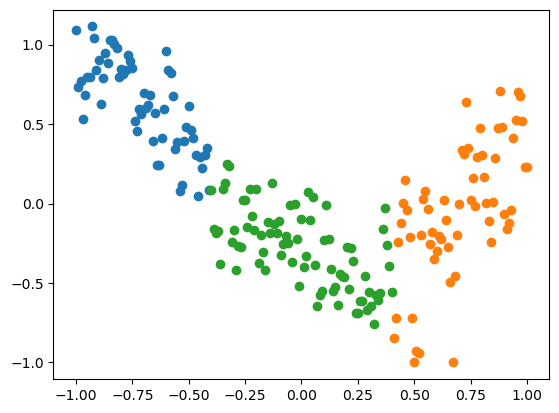

In [12]:
for i in np.arange(1):
    i=8970
    test_lc = lc_np_array[i]

    ph = np.linspace(-1.0,1.0,len(lc_np_array[0]))
    print('len(ph) = ',len(ph))
    plt.scatter(ph[0:60], test_lc[0:60])
    print('len(ph[0:60]) = ',len(ph[0:60]))
    plt.scatter(ph[141:202], test_lc[141:202])
    # print('len(ph[141:202]) = ',len(ph[141:202]))
    plt.scatter(ph[60:141], test_lc[60:141])

    plt.show()

len(ph) =  120
noise_array.shape =  (15737, 120)


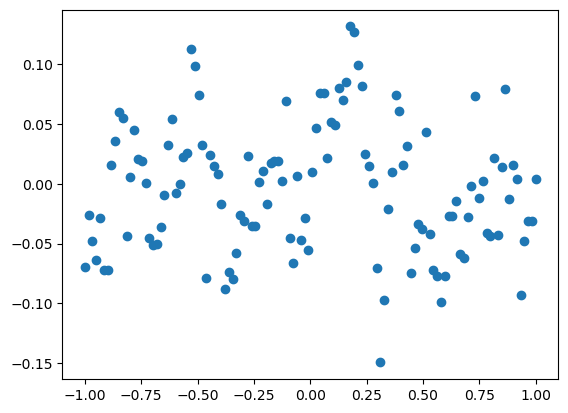

In [13]:
# Noise Array
# Append first 60 and last 60 elements
noise_array = np.zeros((len(lc_np_array),120))
for i in np.arange(len(lc_np_array)):
    noise_array[i][0:60] = lc_np_array[i,0:60]
    noise_array[i][60:120] = lc_np_array[i,141:202]


ph = np.linspace(-1.0,1.0,len(noise_array[0]))
plt.scatter(ph, noise_array[0])
print('len(ph) = ',len(ph))
print('noise_array.shape = ',noise_array.shape)

plt.show()

a =  [1960  695  767  698  628  649  601  564  485  396  319  288  246  262
  339  337  439  486  560  569  524  533  487  415  380  340  279  259
  190  167  156   94   83   77   50   50   36   34   26   17   24   23
   19   10   11   15   13    5    5   14    9   10    9    5    6    2
    5    4    7    4    1    2    2    2    2    4    1    2    1    0
    0    4    1    1    2    2    4    2    0    1    0    2    3    0
    1    0    0    0    1    0    1    2    1    0    0    0    0    0
    0]
a_percent =  [1.24602670e+01 4.41830896e+00 4.87603306e+00 4.43738080e+00
 3.99237127e+00 4.12587413e+00 3.82072473e+00 3.58550540e+00
 3.08328036e+00 2.51748252e+00 2.02797203e+00 1.83089638e+00
 1.56389065e+00 1.66560712e+00 2.15511761e+00 2.14240305e+00
 2.79084552e+00 3.08963764e+00 3.56007629e+00 3.61729180e+00
 3.33121424e+00 3.38842975e+00 3.09599491e+00 2.63827082e+00
 2.41576605e+00 2.16147489e+00 1.77368086e+00 1.64653528e+00
 1.20788303e+00 1.06166561e+00 9.91735537e-01 5.975

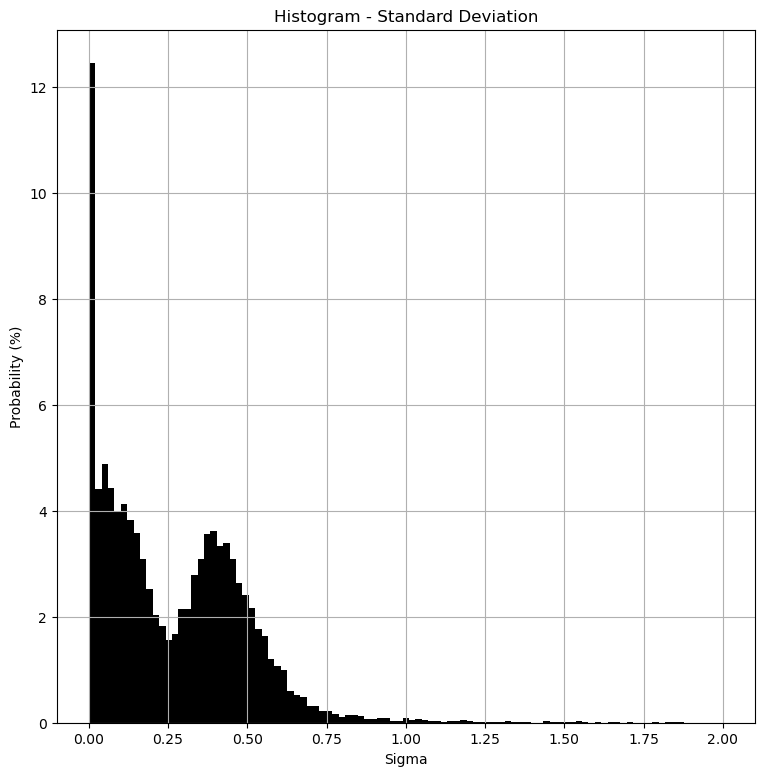

In [14]:
# Calc std dev of the arrays
std_devs_Kepler = np.array([np.std(arr) for arr in noise_array])

# Plot histogram of std dev
# bins = np.logspace(-5,5,100)
# bins = np.linspace(0,10**2,11)
bins = np.linspace(0,2,100)

plt.figure(figsize=(9, 9))
# plt.hist(std_devs_Kepler, bins=bins, density=True, alpha=0.8, color='tab:green')
a,*_ = np.histogram(std_devs_Kepler, bins=bins)
print('a = ',a)
a_percent = (a/np.sum(a))*100
print('a_percent = ',a_percent)

plt.stairs(a_percent, bins, baseline=0,fill=True,color='black')
plt.xlabel('Sigma')
# plt.xscale("log")
plt.ylabel('Probability (%)')
plt.title('Histogram - Standard Deviation')
plt.grid(True)
plt.show()

# Add noise to train lightcurve
#

In [15]:
# Add noise to simulated train light curve, such that index is uniform
index_noise_train= np.random.uniform(0,len(noise_array),(len(train_lc_scaled_append),))
train_lc_scaled_append_noise = np.zeros(train_lc_scaled_append.shape)
print("index_noise_train.shape = ",index_noise_train.shape)
i = 0
for i in np.arange(len(train_lc_scaled_append)):
    index = int(index_noise_train[i])
    print(index)
    train_lc_scaled_append_noise[i] = train_lc_scaled_append[i] + noise_array[index]


index_noise_train.shape =  (132136,)
4651
1603
1503
11425
4963
13121
7629
14407
6908
12483
9759
13426
6494
15094
355
12846
8759
4661
8703
6823
8851
2218
12404
973
1556
13013
2663
3922
9528
757
14897
9900
3401
9862
6688
1292
13824
2879
12668
8474
3668
12832
9100
1842
12777
2011
5849
12452
745
11025
10339
614
13422
14167
5971
5059
5605
9512
12476
5990
6323
10832
2037
9150
6836
10827
14653
8165
1248
13547
11536
13246
11996
11748
11215
14163
13022
4282
965
10792
335
13945
14610
11099
5490
7558
1515
4122
2056
13233
2412
2530
1481
2323
13493
1460
5268
3856
9640
9
2110
7019
403
1019
3580
11534
7234
1814
15298
3455
2345
6854
3189
10264
1229
10245
15581
7163
1323
9930
7010
328
15224
2256
10272
5383
6152
5054
650
12156
4072
11280
1317
10067
14603
6233
7364
13321
512
3623
8027
2802
2811
10296
9319
14913
2936
2340
1024
2732
6533
2446
1811
6290
1141
11480
3361
2111
15581
9598
2883
4873
5353
9363
15380
14504
4641
2207
2932
8522
11654
11529
2864
11593
10673
6036
3266
13385
5779
5370
554
15316
7698
83

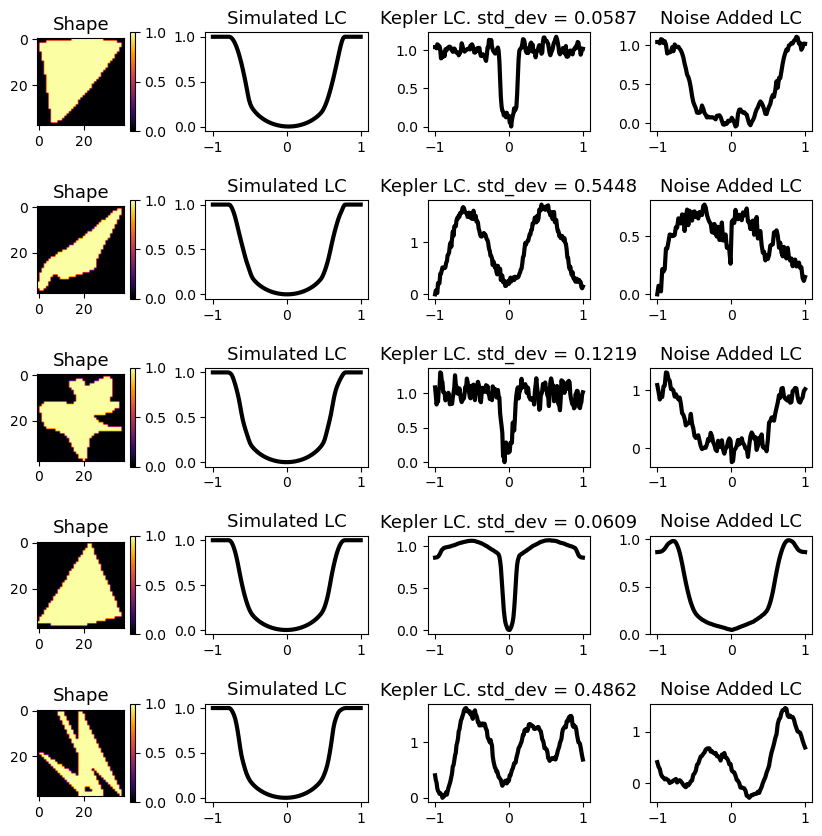

In [16]:
# Plot - Train LCs
num = 5
fig,ax=plt.subplots(num,4, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,3,3,3],
        'wspace': 0.4,'hspace': 0.7})

ph = np.linspace(-1,1,len(train_lc_scaled_append_noise[0]))
ph_kepler = np.linspace(-1,1,len(lc_np_array[0]))

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(train_lc_scaled_append_noise)-1)
    original_kelper_index = int(index_noise_train[int(k)])


    ax[i][0].set_title('Shape',size=13)
    img = ax[i][0].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)

    ax[i][1].set_title('Simulated LC',size=13)
    ax[i][1].plot(ph, train_lc_scaled_append[k],color = 'black',linewidth='3')

    ax[i][2].set_title(f'Kepler LC. std_dev = {np.round(std_devs_Kepler[original_kelper_index],4)}',size=13)
    ax[i][2].plot(ph_kepler, lc_np_array[original_kelper_index]+1,color = 'black',linewidth='3')
    
    ax[i][3].set_title('Noise Added LC',size=13)
    ax[i][3].plot(ph, train_lc_scaled_append_noise[k],color = 'black',linewidth='3')

plt.suptitle("Train Set")

plt.show()


# Adding noise to Validation Dataset

In [21]:
# Add noise to simulated vald light curve, such that index is uniform
index_noise_vald= np.random.uniform(0,len(noise_array),(len(vald_lc_scaled_append),))
vald_lc_scaled_append_noise = np.zeros(vald_lc_scaled_append.shape)
print("index_noise_vald.shape = ",index_noise_vald.shape)
i = 0
for i in np.arange(len(vald_lc_scaled_append)):
    index = int(index_noise_vald[i])
    print(index)
    vald_lc_scaled_append_noise[i] = vald_lc_scaled_append[i] + noise_array[index]

index_noise_vald.shape =  (1000,)
5738
607
11037
6753
12923
6458
3966
7703
4744
6372
3556
15483
10643
9894
11951
10547
14384
8551
7755
6362
1941
7435
9456
7613
15610
9575
313
5717
3249
5732
10093
982
2603
2975
10788
7515
12281
9208
15426
693
4061
10980
463
14693
12202
12974
4176
4198
874
10439
6584
5574
11969
1620
1503
4228
4828
12350
9160
11581
5893
3911
1623
5654
12094
537
6738
10724
9524
13582
12828
12967
10147
12700
6062
14119
9459
14223
13367
12850
13371
1662
12205
1612
13361
6725
1600
6845
9633
3590
10491
5504
3309
14223
7588
6074
7636
9940
11974
13448
1908
4347
9850
4963
2383
9563
9311
7448
1057
13186
8177
13550
4656
6684
7677
15265
89
15021
2848
7471
6171
12936
11287
13980
4129
6288
12221
3082
5557
3577
12813
5523
12229
1657
9858
11881
11830
1280
2189
11056
10779
9748
10840
14244
10587
705
13156
15
7899
10198
4235
13089
8425
9708
2917
1158
3277
10241
1250
9366
13660
4297
7476
4749
15348
10812
7595
10018
9157
1806
4225
2393
14177
2561
13877
12466
1320
1613
3404
9179
3518
568
691

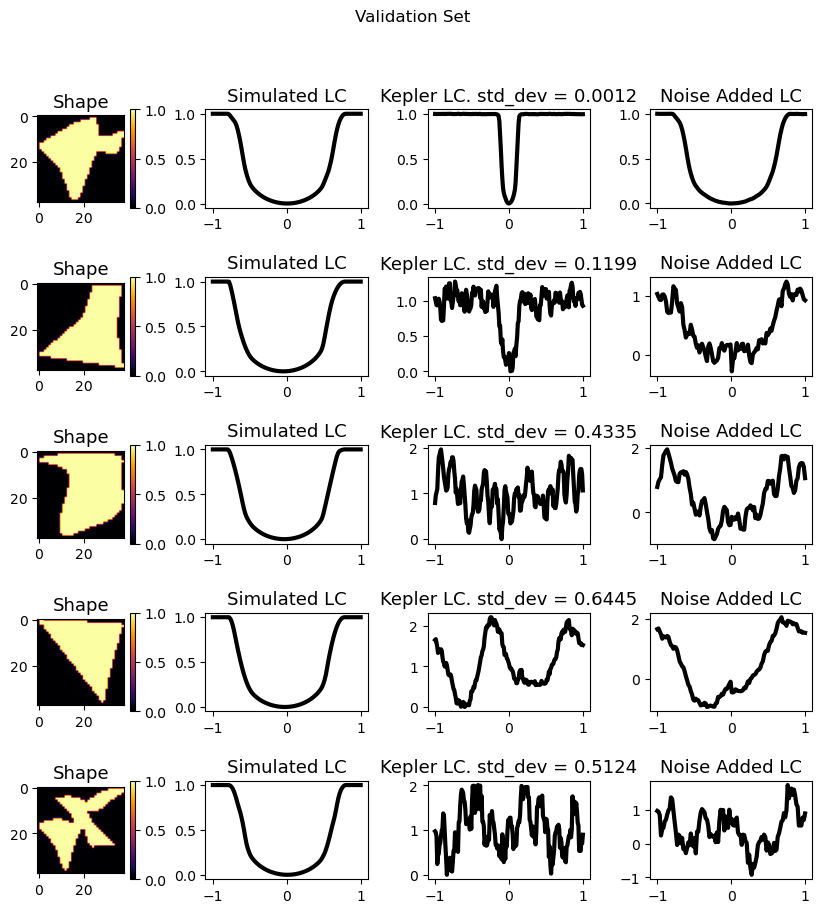

In [26]:
# Plot - Vald LCs
num = 5
fig,ax=plt.subplots(num,4, figsize=(10,10), gridspec_kw={ 'width_ratios': [2,3,3,3],
        'wspace': 0.4,'hspace': 0.7})

ph = np.linspace(-1,1,len(vald_lc_scaled_append_noise[0]))
ph_kepler = np.linspace(-1,1,len(lc_np_array[0]))

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(vald_lc_scaled_append_noise)-1)
    original_kelper_index = int(index_noise_vald[int(k)])


    ax[i][0].set_title('Shape',size=13)
    img = ax[i][0].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)

    ax[i][1].set_title('Simulated LC',size=13)
    ax[i][1].plot(ph, vald_lc_scaled_append[k],color = 'black',linewidth='3')

    ax[i][2].set_title(f'Kepler LC. std_dev = {np.round(std_devs_Kepler[original_kelper_index],4)}',size=13)
    ax[i][2].plot(ph_kepler, lc_np_array[original_kelper_index]+1,color = 'black',linewidth='3')
    
    ax[i][3].set_title('Noise Added LC',size=13)
    ax[i][3].plot(ph, vald_lc_scaled_append_noise[k],color = 'black',linewidth='3')

plt.suptitle("Validation Set")
plt.show()
